# CSI 5139F: Assignment 1

Student: Ao Zhang

Student Number: 0300039680

Student Email: azhan085@uottawa.ca

## 1. Getting Started

As indicated in the assignment description, the dataset *Phos_2_0_2MP* is downloaded.

Then, *os* is used for better organizing the folders' paths; *glob* is used to read the image filenames faster. one of the images is plotted for users to checkout how they look like.

Since we start from *uestion 2*, all the required images (non-uniform illumination and uniform illumination) are seperated into two classes. The labels to the corresponding pictures are defined as:

- **non-uniform illumination**: **2**
- **uniform illumination**: **0**

In [1]:
import matplotlib.pyplot as plt
from skimage.io import imread
import os
import glob
import numpy as np

nonuni_pics = []
uni_pics = []

# read all scene folders
total_folers = glob.glob("../Phos2_0_2MP/Phos2_scene*")

# check out how many folders are there
print("Total number of scenes is: \t \t", len(total_folers))

# read the image filenames according to the category (nonuniform and uniform)
for each_foler in total_folers:
    nonuni_path = os.path.join(each_foler, "*_nonuni_*.png")
    uni_path = os.path.join(each_foler, "*_uni_*.png")
    nonuni_pics += glob.glob(nonuni_path)
    uni_pics += glob.glob(uni_path)

# check out dataset size
print("Number of non-uniform Pictures: \t", len(nonuni_pics))
print("Number of uniform Pictures: \t \t", len(uni_pics))

'''
set classifier as:
1   ->   non-uniform
0   ->   uniform
'''
nonuni_label = 1
uni_label = 0

# define the labels to the corresponding pictures
def DefineLabels(img_names, label, gray = True):
    imgs = []
    labels = []
    for each_img_name in img_names:
        # read images as grayscale
        imgs.append(imread(each_img_name, as_gray = gray))
        labels.append(label)
    imgs = np.array(imgs)
    labels = np.array(labels)
    return imgs, labels

nonuni_imgs, nonuni_labels = DefineLabels(nonuni_pics, nonuni_label)
uni_imgs, uni_labels = DefineLabels(uni_pics, uni_label)

# plot one of the images to check what the image looks like
w, h = nonuni_imgs[0].shape
plt.imshow(nonuni_imgs[0])
plt.show()

Total number of scenes is: 	 	 15
Number of non-uniform Pictures: 	 90
Number of uniform Pictures: 	 	 135


<Figure size 640x480 with 1 Axes>

## 2. Binary Classifier

### The way of splitting the images

**For each class**, before sent into the function *train_test_split()*, the images are first shuffled with labels. 

Then, shuffled images and labels are sent to *train_test_split()*. **60%** of the data are selected as **training set**. Then the rest $40\%$ are sent into *train_test_split()* again and split into **validation set** and **test set** equally.

Therefore,
- **60%** of data are selected randomly as **training data**;.
- **20%** of data are selected randomly as **validation data**;
- **20%** of data are selected randomly as **testing data**;

After training sets, validation sets, testing sets are selected seperately from each class, all training sets are **concatenated** to make the **final training set**. Same operation is applied to make **final validation set** and **final testing set**.

*By doing this, we can make sure the proportions of different classes in the datasets keep the same*

In [2]:
from sklearn.model_selection import train_test_split

'''
principle:
    60% selected as training dataset;
    20% selected as validation dataset;
    20% selected as test dataset.
'''
# shuffle images and labels at the same time
def ShuffleData(imgs, labels):
    index = np.arange(len(imgs))
    np.random.shuffle(index)
    return imgs[index], labels[index]

# first shuffle
nonuni_imgs, nonuni_labels = ShuffleData(nonuni_imgs, nonuni_labels)
uni_imgs, uni_labels = ShuffleData(uni_imgs, uni_labels)

# split the data into train, validation, test
def SplitData(imgs, labels, train_size, validation_size):
    X_train, X_rest, Y_train, Y_rest = train_test_split(imgs, labels, \
                                                        test_size = (1 - train_size), random_state=42)
    X_validation, X_test, Y_validation, Y_test = train_test_split(X_rest, Y_rest, \
                                                          test_size = (1 - validation_size), random_state=42)
    return X_train, X_validation, X_test, Y_train, Y_validation, Y_test

# split nonuniform images and labels into 3 sets
nonuni_Xtrain, nonuni_Xvalidation, nonuni_Xtest, nonuni_Ytrain, nonuni_Yvalidation, nonuni_Ytest = \
                                            SplitData(nonuni_imgs, nonuni_labels, 0.6, 0.5)

uni_Xtrain, uni_Xvalidation, uni_Xtest, uni_Ytrain, uni_Yvalidation, uni_Ytest = \
                                            SplitData(uni_imgs, uni_labels, 0.6, 0.5)

# combine all images and labels into one set and shuffle it
def CombineDataAndShuffle(pre_combined_imgs, pre_combined_labels):
    # combine data
    combined_imgs = np.concatenate(pre_combined_imgs, axis = 0)
    combined_labels = np.concatenate(pre_combined_labels, axis = 0)
    # shuffle
    shuffled_imgs, shuffled_labels = ShuffleData(combined_imgs, combined_labels)
    return shuffled_imgs, shuffled_labels

# get pre-combined imgs and labels
X_train_pre, Y_train_pre = [nonuni_Xtrain, uni_Xtrain], [nonuni_Ytrain, uni_Ytrain]
X_validation_pre, Y_validation_pre = [nonuni_Xvalidation, uni_Xvalidation], [nonuni_Yvalidation, uni_Yvalidation]
X_test, Y_test = [nonuni_Xtest, uni_Xtest], [nonuni_Ytest, uni_Ytest]

# second shuffle
X_train, Y_train = CombineDataAndShuffle(X_train_pre, Y_train_pre)
X_validation, Y_validation = CombineDataAndShuffle(X_validation_pre, Y_validation_pre)
X_test, Y_test = CombineDataAndShuffle(X_test, Y_test)

print("Number of data used for training: \t", len(Y_train))
print("Number of data used for validation: \t", len(Y_validation))
print("Number of data used for test: \t \t", len(Y_test))


Number of data used for training: 	 135
Number of data used for validation: 	 45
Number of data used for test: 	 	 45


### All metrics

all the metrics, including the confusion matrix, the accuracy, the recall and the precision are derived by the *sklearn* functions and printed as follow.

Validation score: 	 0.9555555555555556
Confusion Matrix: 
 [[27  0]
 [ 4 14]]
Accuracy: 		 0.9111111111111111
Recall: 		 1.0
Precision: 		 0.7777777777777778


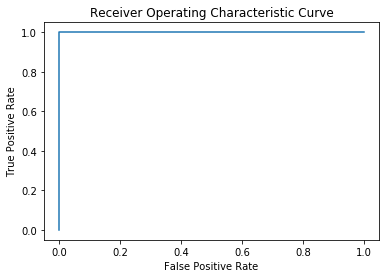

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve

def change_format(data):
    shape = data.shape
    return data.reshape((shape[0], -1))

X_train = change_format(X_train)
X_validation = change_format(X_validation)
X_test = change_format(X_test)

# all parameters not specified are set to their defaults
logistic_regression = LogisticRegression(solver = 'liblinear')

# fit data into model
logistic_regression.fit(X_train, Y_train)

# find out score
score = logistic_regression.score(X_validation, Y_validation)
print("Validation score: \t", score)

# predict labels
Pred_test = logistic_regression.predict(X_test)
Y_score = logistic_regression.decision_function(X_test)

# confusion matrix
confusionmatrix = confusion_matrix(Y_test, Pred_test)

# accuracy
accuracy = accuracy_score(Pred_test, Y_test)

# recall
recall = recall_score(Pred_test, Y_test)

# precision
precision = precision_score(Pred_test, Y_test)

# ROC
fpr, tpr, _ = roc_curve(Y_test, Y_score)

print("Confusion Matrix: \n", confusionmatrix)
print("Accuracy: \t\t", accuracy)
print("Recall: \t\t", recall)
print("Precision: \t\t", precision)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.show()


## 3. Multiclass Classifier

All images are derived into $3$ groups as the problem requires. Also, as usual, one of the images is plotted for visualizing the dataset.

Total images: 	 	 	 225
Underexposed images: 	 	 60
Overexposed images: 	 	 60
Regular images: 	 	 105


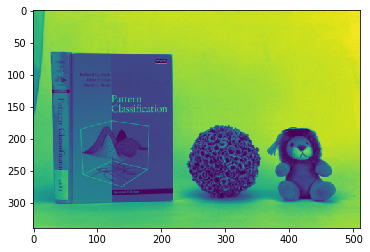

In [4]:
all_img = []
under_exp_img = []
over_exp_img = []

# read the image filenames according to the classes
for each_foler in total_folers:
    all_path = os.path.join(each_foler, "*.png")
    under_path = os.path.join(each_foler, "*_minus_*.png")
    over_path = os.path.join(each_foler, "*_plus_*.png")
    all_img += glob.glob(all_path)
    under_exp_img += glob.glob(under_path)
    over_exp_img += glob.glob(over_path)

# check the total number of images for further checkout
print("Total images: \t \t \t", len(all_img))

# initial regular images
regular_img = all_img

# remove all images shown in under exposed images
for img_i in under_exp_img:
    regular_img.remove(img_i)

# remove all images shown in over exposed images
for img_j in over_exp_img:
    regular_img.remove(img_j)
    
# check out dataset size
print("Underexposed images: \t \t", len(under_exp_img))
print("Overexposed images: \t \t", len(over_exp_img))
print("Regular images: \t \t", len(regular_img))

# set labels
'''
set classifier as:
0   ->   underexposed
1   ->   overexposed
2   ->   regular
'''
under_label = 0
over_label = 1
regular_label = 2

# define the labels to the corresponding pictures
underexp_imgs, underexp_labels = DefineLabels(under_exp_img, under_label)
overexp_imgs, ovexp_labels = DefineLabels(over_exp_img, over_label)
regular_imgs, regular_labels = DefineLabels(regular_img, regular_label)

# plot one of the images to check what the image looks like
plt.imshow(underexp_imgs[0])
plt.show()


### Data Splitting

**Same trick as the last question**, which is images are splitted into training set, validation set and test set with proportion $60\%$, $20\%$ and $20\%$ respectively **in each class**. Then, all training sets, validation sets and test sets are combined together into $3$ sets.

### Metrics

The **confusion matrix** and the **accuracy** are printed at the end of the cell.

In [5]:
def SplitAndMerge(underexp_imgs, underexp_labels, overexp_imgs, 
                  ovexp_labels, regular_imgs, regular_labels):
    # first shuffle
    underexp_imgs, underexp_labels = ShuffleData(underexp_imgs, underexp_labels)
    overexp_imgs, ovexp_labels = ShuffleData(overexp_imgs, ovexp_labels)
    regular_imgs, regular_labels = ShuffleData(regular_imgs, regular_labels)

    # split images and labels into 3 sets
    under_Xtrain, under_Xvalidation, under_Xtest, under_Ytrain, under_Yvalidation, under_Ytest = \
                                                SplitData(underexp_imgs, underexp_labels, 
                                                          0.6, 0.5)

    over_Xtrain, over_Xvalidation, over_Xtest, over_Ytrain, over_Yvalidation, over_Ytest = \
                                                SplitData(overexp_imgs, ovexp_labels, 
                                                          0.6, 0.5)

    regular_Xtrain, regular_Xvalidation, regular_Xtest, regular_Ytrain, regular_Yvalidation, regular_Ytest = \
                                                SplitData(regular_imgs, regular_labels, 
                                                          0.6, 0.5)

    # get pre-combined imgs and labels
    X_train_pre, Y_train_pre = [under_Xtrain, over_Xtrain, regular_Xtrain], [under_Ytrain, over_Ytrain, regular_Ytrain]
    X_validation_pre, Y_validation_pre = [under_Xvalidation, over_Xvalidation, regular_Xvalidation], \
                                        [under_Yvalidation, over_Yvalidation, regular_Yvalidation]
    X_test, Y_test = [under_Xtest, over_Xtest, regular_Xtest], [under_Ytest, over_Ytest, regular_Ytest]

    # second shuffle
    X_train, Y_train = CombineDataAndShuffle(X_train_pre, Y_train_pre)
    X_validation, Y_validation = CombineDataAndShuffle(X_validation_pre, Y_validation_pre)
    X_test, Y_test = CombineDataAndShuffle(X_test, Y_test)
   
    return X_train, Y_train, X_validation, Y_validation, X_test, Y_test

# format data into training set, validation set and test set
X_train_img, Y_train, X_validation_img, Y_validation, X_test_img, Y_test = \
            SplitAndMerge(underexp_imgs, underexp_labels, overexp_imgs, 
                              ovexp_labels, regular_imgs, regular_labels)

# change image from (N, w, h) to (N, -1)
X_train = change_format(X_train_img)
X_validation = change_format(X_validation_img)
X_test = change_format(X_test_img)

# all parameters not specified are set to their defaults
logistic_regression_multi = LogisticRegression(solver='lbfgs', multi_class='multinomial')

# fit data into model
logistic_regression_multi.fit(X_train, Y_train)

# find out score
score = logistic_regression_multi.score(X_validation, Y_validation)

print("Validation score: \t", score)

def MeticsCalculation(model, X_validation, Y_validation, X_test, Y_test):
    # predict labels
    Pred_test = logistic_regression_multi.predict(X_test)

    # confusion matrix
    confusionmatrix = confusion_matrix(Y_test, Pred_test)

    # accuracy
    accuracy = accuracy_score(Pred_test, Y_test)

    print("Confusion Matrix: \n", confusionmatrix)
    print("Accuracy: \t\t", accuracy)

# calculate all necessary metrics
MeticsCalculation(logistic_regression_multi, X_validation, Y_validation, 
                  X_test, Y_test)

Validation score: 	 0.9333333333333333
Confusion Matrix: 
 [[11  0  1]
 [ 0 11  1]
 [ 3  1 17]]
Accuracy: 		 0.8666666666666667


/home/ao/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


## 4. Improved Classification of Colour Images

### Re-read images as RGB and Build the classifier

First of all, according to the question, images are re-read with RGB channels, then fed into the same model as question $(1.3)$ and named as *logistic_regression_color*

In [6]:
"""
Try color images first.
"""
# define the labels to the corresponding pictures
underexp_imgs, underexp_labels = DefineLabels(under_exp_img, under_label, False)
overexp_imgs, overexp_labels = DefineLabels(over_exp_img, over_label, False)
regular_imgs, regular_labels = DefineLabels(regular_img, regular_label, False)

# format data into training set, validation set and test set
X_train_img, Y_train, X_validation_img, Y_validation, X_test_img, Y_test = \
            SplitAndMerge(underexp_imgs, underexp_labels, overexp_imgs, 
                              ovexp_labels, regular_imgs, regular_labels)

# change image from (N, w, h) to (N, -1)
X_train = change_format(X_train_img)
X_validation = change_format(X_validation_img)
X_test = change_format(X_test_img)

# fit data into model
logistic_regression_multi.fit(X_train, Y_train)

# calculate all necessary metrics
MeticsCalculation(logistic_regression_multi, X_validation, Y_validation, 
                  X_test, Y_test)


Confusion Matrix: 
 [[ 8  0  4]
 [ 0 10  2]
 [ 0  0 21]]
Accuracy: 		 0.8666666666666667


/home/ao/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


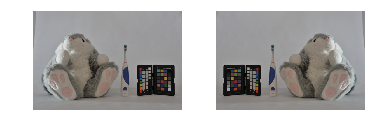

In [7]:
"""
Using flipping to propagate new images.
"""
# flip the images
def ImageLabelFlip(imgs, labels):
    new_labels = labels
    new_imgs_h = imgs
    new_imgs_h = new_imgs_h[:, :, ::-1, ...]
    new_imgs = np.concatenate([imgs, new_imgs_h], axis = 0)
    new_labels = np.concatenate([new_labels, labels])
    return new_imgs, new_labels

# record the len the original data for plotting
num_len = len(X_train_img)

# flip the image to improve the training data
X_train_improve_img, Y_train_improve = ImageLabelFlip(X_train_img, Y_train)

# plot the images to see the change
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.axis("off")
ax2.axis("off")
ax1.imshow(X_train_improve_img[0])
ax2.imshow(X_train_improve_img[num_len])



In [8]:
"""
Check the influence on the result.
"""
# change image from (N, w, h) to (N, -1)
X_train_improve = change_format(X_train_improve_img)

# fit data into model
logistic_regression_multi.fit(X_train_improve, Y_train_improve)

# calculate all necessary metrics
MeticsCalculation(logistic_regression_multi, X_validation, Y_validation, 
                  X_test, Y_test)

Confusion Matrix: 
 [[ 8  0  4]
 [ 0  9  3]
 [ 0  1 20]]
Accuracy: 		 0.8222222222222222


/home/ao/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [9]:
from skimage.transform import resize

all_img = []
under_exp_img = []
over_exp_img = []

# read all scene folders
total_folers = glob.glob("../Phos2_0_5MP/Phos2_scene*")

# read the image filenames according to the classes
for each_foler in total_folers:
    all_path = os.path.join(each_foler, "*.png")
    under_path = os.path.join(each_foler, "*_minus_*.png")
    over_path = os.path.join(each_foler, "*_plus_*.png")
    all_img += glob.glob(all_path)
    under_exp_img += glob.glob(under_path)
    over_exp_img += glob.glob(over_path)

# check the total number of images for further checkout
print("Total images: \t \t \t", len(all_img))
    
# initial regular images
regular_img = all_img

# remove all images shown in under exposed images
for img_i in under_exp_img:
    regular_img.remove(img_i)

# remove all images shown in over exposed images
for img_j in over_exp_img:
    regular_img.remove(img_j)
    
# check out dataset size
under_ori = imread(under_exp_img[np.random.randint(len(under_exp_img))])
over_ori = imread(over_exp_img[np.random.randint(len(over_exp_img))])
regular_ori = imread(regular_img[np.random.randint(len(regular_img))])

# read the images
under_img = np.expand_dims(resize(under_ori, (w, h)), axis = 0)
over_img = np.expand_dims(resize(over_ori, (w, h)), axis = 0)
regular_img = np.expand_dims(resize(regular_ori, (w, h)), axis = 0)

# transfer the format
under_img = change_format(under_img)
over_img = change_format(over_img)
regular_img = change_format(regular_img)


Total images: 	 	 	 225


label is: 	 underexposed


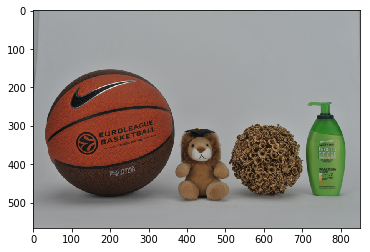

label is: 	 overexposed


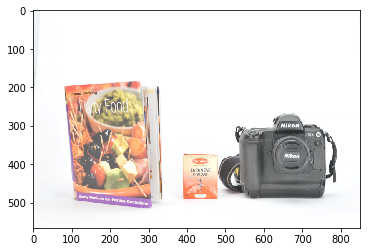

label is: 	 regular


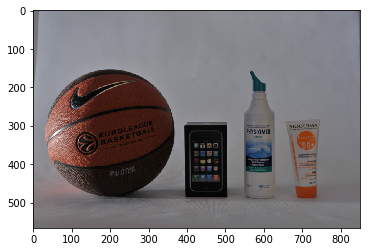

In [10]:
import matplotlib.cm as cm
'''
set classifier as:
0   ->   underexposed
1   ->   overexposed
2   ->   regular
'''
def TransferLabel(pred):
    if pred[0] == 0:
        pred = "underexposed"
    elif pred[0] == 1:
        pred = "overexposed"
    elif pred[0] == 2:
        pred = "regular"
    else:
        "not recognized"
    return pred

# use model to predict
under_pred = logistic_regression_multi.predict(under_img)
over_pred = logistic_regression_multi.predict(over_img)
regular_pred = logistic_regression_multi.predict(regular_img)

# transfer labels to readable
under_label = TransferLabel(under_pred)
over_label = TransferLabel(over_pred)
regular_label = TransferLabel(regular_pred)

# plot out
plt.imshow(under_ori)
print("label is: \t", under_label)
plt.show()
plt.imshow(over_ori)
print("label is: \t", over_label)
plt.show()
plt.imshow(regular_ori)
print("label is: \t", regular_label)
plt.show()